In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # python library for Regular Expressions
# import sql libraries
# a hack to print all my cell outputs / change 'all' to 'last_expr' to revert to default
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [79]:
# load in the data
restaurants_yelp_df = pd.read_csv('../data/yelp_restaurant_df.csv')
restaurants_foursquares_df = pd.read_csv('../data/foursquares_restaurant_df.csv')
rentals_yelp_df = pd.read_csv('../data/yelp_car_rentals_df.csv')
rentals_foursquares_df = pd.read_csv('../data/foursquares_car_rentals_df.csv')
stations_df = pd.read_csv('../data/stations_df.csv')

In [80]:
rentals_foursquares_df.head()
rentals_yelp_df.head()

,Name,Bike Station Id,Category
0,Avis Rent A Car,0,['Rental Car Location']
1,Budget Truck Rental,0,['Rental Car Location']
2,Advantage Rent A Car,0,['Rental Car Location']
3,Enterprise Rent-A-Car,0,['Rental Car Location']
4,Flight Car,0,['Rental Car Location']


,Name,Review Count,Ratings,Bike Station Id,Category
0,National Car Rental,84,3.5,1,['carrental']
1,Rental Car Center Boston,1,3.0,1,['carrental']
2,Avis Car Rental,240,1.5,1,['carrental']
3,Thrifty Car Rental,201,1.5,1,['carrental']
4,Advantage Rental Cars,117,1.0,1,['carrental']


# Join the data from Part 1 with the data from Part 2 to create a new dataframe.

This will be done in 3 stages:

1. Using `.concat()` to merge the 2 Restaurant dataframes (from Yelp and FourSquares), and the 2 Rentals dataframes (from Yelp and FourSquares) into one restaurants_df and bikerentals_df respectively.
    - Cleaning the dataframes - removing duplicates, fixing missing data, etc.
1. Merging the restaurants_df and bikerentals_df into the final `points_of_interest_df`  with `.concat()`
2. Merging the `points_of_interest_df` with the citybikes `stations_df` with `.merge()`

### 1. Creating the `restaurants_df` and `bikerentals_df`

**Further Data Cleaning for the Database**:

1. Simplify the `Category` columns to just `Restaurant` or `Bike rentals`.

2. Fill the missing values of `Reviews` with the average Review for that Category.

3. Fill the missing values of `Ratings` with the minimum Ratings in that Category.

In [81]:
# dropping the Category columns
for df in [restaurants_yelp_df, 
           restaurants_foursquares_df,
           rentals_yelp_df,
           rentals_foursquares_df]:
    df.drop(columns = 'Category', inplace=True)

# Concatenating the dataframes & adding a simpler Category column
rentals_df = pd.concat([rentals_yelp_df, rentals_foursquares_df])
rentals_df['Category'] = 'Car Rental'
restaurants_df = pd.concat([restaurants_yelp_df, restaurants_foursquares_df])
restaurants_df['Category'] = 'Restaurant'

### Handling Duplicates: Cleaning the Names columns

Quick inspection on Excel spreadsheet shows that many names of the businesses appear to be duplicates (`Avis Rental Car` vs `Avis Car Rental` vs `Avis CarRental` vs `Avis's Car Rental` which are all listed as unique values.

I used the Python Regex library and some string formatting techniques to do some quick data cleaning...

In [82]:
def simplify(Name):
    '''
    Argument: LIST of sentence strings usually representing a column of names in a dataframe
    simplifies the names
    returns: a LIST of strings of the same length
    be mindful of python strings and copying traps
    '''
    Names = Name.copy()
    # dictionary of non-exhaustive replacement words
    dictionary = {
    '/':" ",
    'grille': 'grill',
    'caf' : 'cafe',
    'cafee': 'cafe',
    'coffee': 'cafe',
    '&': 'and',
    '  ': ' ',
    '’' : "'",
    'cars': 'car',
    'carrental' : 'car rental',
    'rental car': 'car rental',
    'rent-a-car' : 'car rental',
    'rent a car': 'car rental',
    'rentacar': 'car rental',
    'auto van and truck': 'auto',
    'auto van': 'auto',
    'auto car': 'auto',
    'auto and truck': 'auto',
    'rental van': 'van rental',
    'rental truck': 'truck rental'
    }


    for i, name in enumerate(Names):
        acronmym_check = bool(re.search(r"([A-Z]{3,9})", name))
        name = name.encode('ascii', 'ignore').decode('ascii') 
        name = re.sub(r'([a-z])-([a-z])', r'\1\2', name) #removing hyphens
        name = re.sub(r"([a-zA-NP-Z]+)'([a-rt-zA-RT-Z])", r"\1\2", name) # removing middle quotes
        name = re.sub(r"([a-z])([A-Z])", r"\1 \2", name)
        name = name.lower()
        for check in  dictionary:
            name = name.replace(check, dictionary[check])
        if acronmym_check:
            name = name.upper()
        else:
            name = name.title()
        name = name.replace("'S", "'s")
        Names[i] = name
    return Names

In [83]:
# check unique names before calling the function
rentals_df['Name'].nunique()
Names = list(rentals_df['Name'].copy()) # must copy it into a separate list variable first
NewNames = simplify(Names)
rentals_df.loc[:, 'Name'] = NewNames # assign with .loc
rentals_df['Name'].nunique() # check unique names again after function
# 156 to 150 last run

156

150

In [84]:
# check unique names before calling the function
restaurants_df['Name'].nunique()
Names = list(restaurants_df['Name'].copy()) # must copy it into a separate list variable first
NewNames = simplify(Names)
restaurants_df.loc[:, 'Name'] = NewNames # assign with .loc
restaurants_df['Name'].nunique() # check unique names again after function
# 4054 to 4002

4054

4002

In [85]:
# Spot check before removing duplicates
rentals_df.info()
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3436 entries, 0 to 3038
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             3436 non-null   object 
 1   Review Count     397 non-null    float64
 2   Ratings          397 non-null    float64
 3   Bike Station Id  3436 non-null   int64  
 4   Category         3436 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 161.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27745 entries, 0 to 18994
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             27745 non-null  object 
 1   Review Count     8750 non-null   float64
 2   Ratings          8750 non-null   float64
 3   Bike Station Id  27745 non-null  int64  
 4   Category         27745 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [88]:
# Dropping duplicated data, keeping the rows from the Yelp dataframe because they have more information
rentals_df.drop_duplicates(subset=['Name', 'Bike Station Id'], keep='first', inplace=True, ignore_index=True)
rentals_df.info()

restaurants_df.drop_duplicates(subset=['Name', 'Bike Station Id'], keep='first', inplace=True, ignore_index=True)
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             3138 non-null   object 
 1   Review Count     397 non-null    float64
 2   Ratings          397 non-null    float64
 3   Bike Station Id  3138 non-null   int64  
 4   Category         3138 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 122.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24072 entries, 0 to 24071
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             24072 non-null  object 
 1   Review Count     8750 non-null   float64
 2   Ratings          8750 non-null   float64
 3   Bike Station Id  24072 non-null  int64  
 4   Category         24072 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 940.4+ KB


**Observation**:

`Null` values of Review Count and Ratings are substantial in Restaurants, and less substantial in Car Rentals. Will replace the value of Rating with the median values of Rating, and the values of Review Count with the minimum value.

In [89]:
### Treating Null values
for df in [restaurants_df, rentals_df]:
    df['Ratings'].fillna(round    ((2* df['Ratings'].median())/2), inplace=True) # rounding to nearest 0.5
    df['Review Count'].fillna(df['Review Count'].min(), inplace=True)
    # converting review count back to integer values
    df['Review Count'] = df['Review Count'].astype(int)

In [90]:
rentals_df.info()
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             3138 non-null   object 
 1   Review Count     3138 non-null   int64  
 2   Ratings          3138 non-null   float64
 3   Bike Station Id  3138 non-null   int64  
 4   Category         3138 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 122.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24072 entries, 0 to 24071
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             24072 non-null  object 
 1   Review Count     24072 non-null  int64  
 2   Ratings          24072 non-null  float64
 3   Bike Station Id  24072 non-null  int64  
 4   Category         24072 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 940.4+ KB


In [91]:
rentals_df.describe()
restaurants_df.describe()

,Review Count,Ratings,Bike Station Id
count,3138.000000,3138.000000,3138.000000
mean,4.611217,2.055609,208.184194
std,20.106171,0.427030,132.018931
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,88.000000
50%,1.000000,2.000000,201.000000
75%,1.000000,2.000000,316.000000
max,240.000000,5.000000,442.000000


,Review Count,Ratings,Bike Station Id
count,24072.000000,24072.000000,24072.000000
mean,125.592348,3.996178,217.399884
std,374.466490,0.399755,127.345566
min,0.000000,0.000000,0.000000
25%,0.000000,4.000000,107.000000
50%,0.000000,4.000000,217.000000
75%,62.000000,4.000000,326.000000
max,5981.000000,5.000000,442.000000


In [92]:
rentals_df.to_csv('../data/rentals_df.csv', index=False)
restaurants_df.to_csv('../data/restaurants_df.csv', index=False)

### 2. Creating the `points_of_interest_df`

In [95]:
points_of_interest = pd.concat([restaurants_df, rentals_df], ignore_index=True)
points_of_interest.head()

,Name,Review Count,Ratings,Bike Station Id,Category
0,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant
1,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant
2,New Saigon,201,4.5,0,Restaurant
3,Melodias,12,4.0,0,Restaurant
4,Renegade's Pub,126,4.0,0,Restaurant


### 3. Joining the `points_of_interest_df` to the `stations_df`

Note: `'Bike Station ID'` corresponds to the index of the CityBikes `stations_df` and will act as a Key when building the SQL Database.

In [97]:
stations_and_places = stations_df.merge(points_of_interest,
                                           left_index=True,
                                           right_on = 'Bike Station Id')
stations_and_places

,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Name,Review Count,Ratings,Bike Station Id,Category
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant
1,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant
2,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,New Saigon,201,4.5,0,Restaurant
3,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Melodias,12,4.0,0,Restaurant
4,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Renegade's Pub,126,4.0,0,Restaurant
...,...,...,...,...,...,...,...,...,...,...
27205,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,31,9930aaf1ad9f4716ff669b09a5c4684f,Alamo,1,2.0,442,Car Rental
27206,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,31,9930aaf1ad9f4716ff669b09a5c4684f,Enterprise Car Rental,1,2.0,442,Car Rental
27207,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,31,9930aaf1ad9f4716ff669b09a5c4684f,Hertz Sheraton Boston Hotel,1,2.0,442,Car Rental
27208,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,31,9930aaf1ad9f4716ff669b09a5c4684f,Zipcar Park Sq Motor Mart Garage,1,2.0,442,Car Rental


In [98]:
stations_and_places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27210 entries, 0 to 27209
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Station Name     27210 non-null  object 
 1   Latitude         27210 non-null  float64
 2   Longitude        27210 non-null  float64
 3   Number of Bikes  27210 non-null  int64  
 4   Station ID       27210 non-null  object 
 5   Name             27210 non-null  object 
 6   Review Count     27210 non-null  int64  
 7   Ratings          27210 non-null  float64
 8   Bike Station Id  27210 non-null  int64  
 9   Category         27210 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 2.3+ MB


In [99]:
stations_and_places.groupby('Bike Station Id')['Category'].value_counts().to_frame() # displays this as a df

Category
Bike Station Id Category            
0               Restaurant        39
                Car Rental         5
1               Restaurant        60
                Car Rental        16
2               Restaurant        60
...                              ...
440             Car Rental        18
441             Restaurant        61
                Car Rental        18
442             Restaurant        61
                Car Rental        18

[854 rows x 1 columns]

## Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

* Interested in analyzing the following relationships with number of bikes in a station:
    - Number of bike rentals in that region,
    - Number of restaurants in that region
    - Average rating for restaurants in that region
    - Average rating for rentals in that region
    
From this point, the data is being gathered for model building and will be treated as such. I made a copy of the original `stations_df` DataFrame, called `stations_model`. The `stations_df` DataFrame will be stored in the SQLite database.

In [100]:
# Creating additional columns for the Number of rentals and restaurants
stations_model = stations_df.copy()
number_of_restaurants = restaurants_df.groupby('Bike Station Id').count()['Category']
number_of_rentals = rentals_df.groupby('Bike Station Id').count()['Category']

stations_model['Number of Restaurants'] = number_of_restaurants
stations_model['Number of Rentals'] = number_of_rentals

stations_model.info() # Checking for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Station Name           443 non-null    object 
 1   Latitude               443 non-null    float64
 2   Longitude              443 non-null    float64
 3   Number of Bikes        443 non-null    int64  
 4   Station ID             443 non-null    object 
 5   Number of Restaurants  443 non-null    int64  
 6   Number of Rentals      411 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 24.4+ KB


In [101]:
# Null values in 'number of rentals' means no rentals were found in that region and should be filled with zeros.
stations_model.fillna(0, inplace=True)
stations_model['Number of Rentals'] = stations_model['Number of Rentals'].astype(int) # change type back to integer

# inspecting the new dataframe
stations_model.info()
stations_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Station Name           443 non-null    object 
 1   Latitude               443 non-null    float64
 2   Longitude              443 non-null    float64
 3   Number of Bikes        443 non-null    int64  
 4   Station ID             443 non-null    object 
 5   Number of Restaurants  443 non-null    int64  
 6   Number of Rentals      443 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 24.4+ KB


,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Number of Restaurants,Number of Rentals
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,39,5
1,Maverick Square - Lewis Mall,42.368844,-71.039778,33,93542dcbf21f5411569adb92cd7cc199,60,16
2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16,d9c7ef5dbda4ed944d1bf51fe540acb6,60,16
3,Bennington St at Byron St,42.383533,-71.016191,15,0568389e659e679fbe29a5ac12cd49c0,52,7
4,Boston East - 126 Border St,42.373312,-71.041020,15,47b79abc28a54d0e4689b1096ceb8466,60,9


In [113]:
# Populating the new columns for 'Rental Ratings and Restaurant Ratings'

# Taking the mean value of the review_count as the cut-off mark for ratings. 
# Due to the large range between minimum and maximum values, it's only fair
# to include ratings with reviews less than the mean.

# create 2 filters - for the reviews cut-off and for the category type

mean_restaurant_review_count = restaurants_df['Review Count'].mean()
filter1 = stations_and_places['Category'] == 'Restaurant'
filter2 = stations_and_places['Review Count'] > 0.4*mean_restaurant_review_count

stations_model['Average Restaurant Rating'] = \
stations_and_places[filter1 & filter2].\
    groupby('Bike Station Id')['Ratings'].mean().to_frame()


# mean_rental_review_count = rentals_df['Review Count'].mean()
filter3 = stations_and_places['Category'] == 'Car Rental'

stations_model['Average Rental Rating'] = \
stations_and_places[filter3].\
    groupby('Bike Station Id')['Ratings'].mean().to_frame()

In [114]:
# Inspecting the null values...

stations_model.info()
stations_model[stations_model.isna().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Station Name               443 non-null    object 
 1   Latitude                   443 non-null    float64
 2   Longitude                  443 non-null    float64
 3   Number of Bikes            443 non-null    int64  
 4   Station ID                 443 non-null    object 
 5   Number of Restaurants      443 non-null    int64  
 6   Number of Rentals          443 non-null    int64  
 7   Average Restaurant Rating  442 non-null    float64
 8   Average Rental Rating      411 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 31.3+ KB


,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Number of Restaurants,Number of Rentals,Average Restaurant Rating,Average Rental Rating
41,Farragut Rd at E. 6th St,42.333400,-71.024950,23,14d397c0588d376d9be5da29016e63d9,29,0,3.777778,NaN
43,Belgrade Ave at Walworth St,42.286346,-71.136721,15,cf762de9024f8015246e7b81550d757b,51,0,4.033333,NaN
65,Spaulding Rehabilitation Hospital - Charlestow...,42.378338,-71.048927,19,6914c1962c64ca2a1c5f7bba047d9788,50,0,3.961538,NaN
68,Forest Hills,42.300923,-71.114249,40,f52e535ba7fd2385a733863f695c9bda,37,0,3.961538,NaN
129,Edwards Playground - Main St at Eden St,42.378965,-71.068607,19,f10d6a600af972c6b5d7953c49d5c654,59,0,3.900000,NaN
169,Murphy Skating Rink - 1880 Day Blvd,42.336448,-71.023739,19,0b0ef90ed68e023d65ed3b1c57eb6d36,27,0,3.875000,NaN
191,Medford St at Charlestown BCYF,42.380429,-71.060557,19,720d74e505e763b75d87e20e94201f88,61,0,3.850000,NaN
201,American Legion Hwy at Cummins Hwy,42.278812,-71.116877,15,fc1d2f7521518949d9e05738824a69cc,32,0,3.611111,NaN
209,University of Massachusetts Boston - Campus Ce...,42.312189,-71.036486,19,f218d7063b0b2efef761e9e74a435475,9,0,NaN,NaN
217,Geiger Gibson Community Health Center,42.318865,-71.045368,19,aa11612d2601810e571ca29ae73f4c53,31,0,3.708333,NaN


### Observation: 

The `NaN` values in the `Average Rental Ratings` are stations where there are no Rental Cars in the region, and hence a Rating of NaN. The `NaN` in the Average Restaurant column was because the Number of Reviews were too low for its Rankings to be considered. 

I will regard all these records as outliers and delete them.

In [115]:
stations_model.dropna(inplace=True)

In [116]:
# Saving updated stations_model database
# This will be used in subsequent model building
stations_model.to_csv('../data/stations_model.csv', index=False)
pd.read_csv('../data/stations_model.csv').head()

,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Number of Restaurants,Number of Rentals,Average Restaurant Rating,Average Rental Rating
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,39,5,4.090909,2.000000
1,Maverick Square - Lewis Mall,42.368844,-71.039778,33,93542dcbf21f5411569adb92cd7cc199,60,16,4.035714,2.031250
2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16,d9c7ef5dbda4ed944d1bf51fe540acb6,60,16,4.035714,2.031250
3,Bennington St at Byron St,42.383533,-71.016191,15,0568389e659e679fbe29a5ac12cd49c0,52,7,4.192308,2.285714
4,Boston East - 126 Border St,42.373312,-71.041020,15,47b79abc28a54d0e4689b1096ceb8466,60,9,4.033333,2.055556


## Visualization

### Histograms and Scatterplots: 
These visualizations will help be identify outliers and spot trends and patterns in the data.

In [117]:
stations_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 0 to 442
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Station Name               411 non-null    object 
 1   Latitude                   411 non-null    float64
 2   Longitude                  411 non-null    float64
 3   Number of Bikes            411 non-null    int64  
 4   Station ID                 411 non-null    object 
 5   Number of Restaurants      411 non-null    int64  
 6   Number of Rentals          411 non-null    int64  
 7   Average Restaurant Rating  411 non-null    float64
 8   Average Rental Rating      411 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 32.1+ KB


In [118]:
sns.set_theme()

<Axes: ylabel='Frequency'>

Text(0.5, 0, 'Number of Bikes')

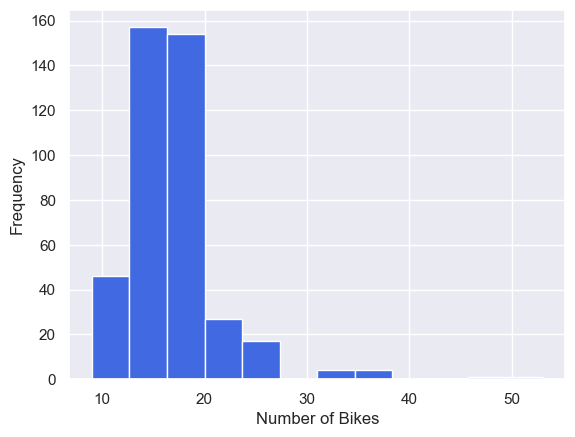

In [154]:
stations_model['Number of Bikes'].plot.hist(bins=12, color='royalblue')
plt.xlabel('Number of Bikes')
plt.savefig('../images/bikes_distribution.png', bbox_inches='tight')

**Analysis**: The values for Number of Bikes are mostly between 10 and 30, with a few outliers above 40. 

Most of the stations (>300) have an average number of bikes between 15-20, and this could be the result of a company standard, since they're all Blue Bike stations.  Perhaps the stations with fewer or more bikes were tailored to the population density or the availability of biking spaces for those specific regions. A map analysis will provide more information.

<Axes: ylabel='Frequency'>

Text(0.5, 0, 'Number of Restaurants')

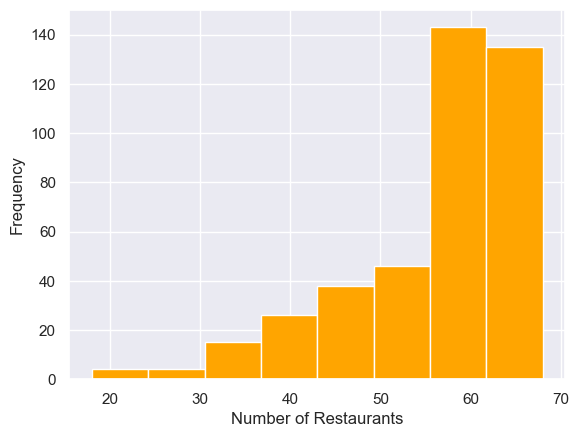

In [155]:
stations_model['Number of Restaurants'].plot.hist(bins=8, color='orange')
plt.xlabel('Number of Restaurants')

Text(0.5, 0, 'Number of Bikes')

Text(0, 0.5, 'Number of Restaurants')

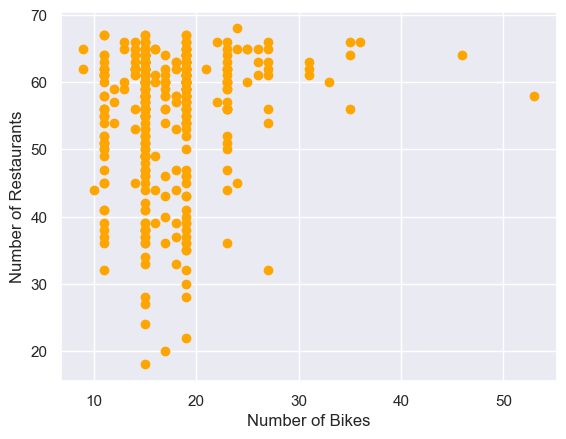

In [156]:
plt.scatter(stations_model['Number of Bikes'], stations_model['Number of Restaurants'], color='orange')
plt.xlabel ('Number of Bikes')
plt.ylabel ('Number of Restaurants')

**Analysis**: From the histogram, the distribution of the Number of Restaurants skews to the left. There are more Restaurants within stations. 

The scatter plot shows no correlation between these values. The number of restaurants does not seem to be affected by the size of the neigbouring bike stations. 

<Axes: ylabel='Frequency'>

Text(0.5, 0, 'Number of Rentals')

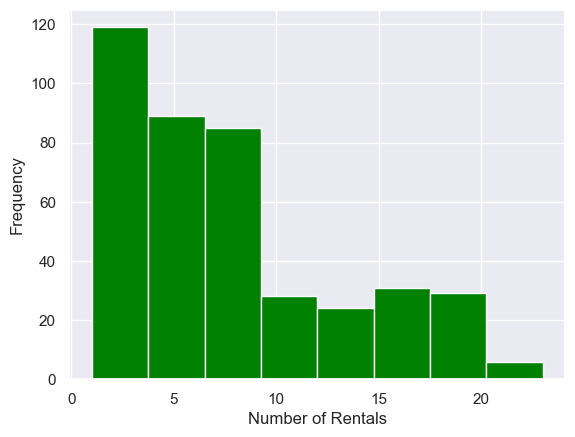

In [157]:
stations_model['Number of Rentals'].plot.hist(bins=8, color='green')
plt.xlabel('Number of Rentals')

Text(0.5, 0, 'Number of Bikes')

Text(0, 0.5, 'Number of Rentals')

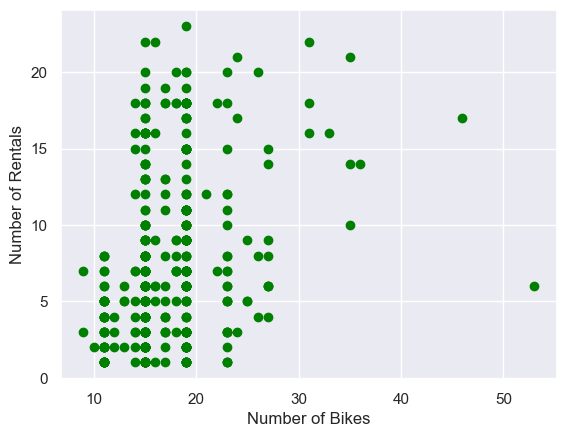

In [158]:
plt.scatter(stations_model['Number of Bikes'], stations_model['Number of Rentals'], color='green')
plt.xlabel ('Number of Bikes')
plt.ylabel ('Number of Rentals')

**Analysis**: From the histogram, the Number of Rentals skews to the right. The scatter plot shows no clear relationship between the Number of Bikes and the Number of Rentals.

<Axes: ylabel='Frequency'>

<Axes: ylabel='Frequency'>

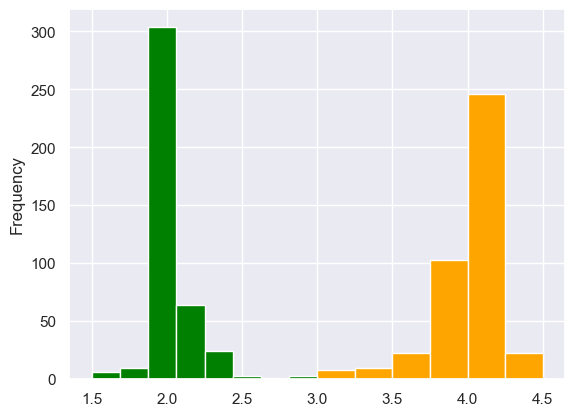

In [159]:
stations_model['Average Restaurant Rating'].plot.hist(bins=8, color='orange', label='Restaurant')
# plt.xlabel('Average Rating')

stations_model['Average Rental Rating'].plot.hist(bins=8, color='green', label='Rental')
# plt.xlabel('Average  Rating')
plt.title = 'Average Rating'

plt.savefig('../images/histogram_of_ratings.png', bbox_inches='tight')

**Observation**: Restaurants are generally rated higher than Rentals which are mostly average.

Text(0.5, 0, 'Number of Bikes')

Text(0, 0.5, 'Rating')

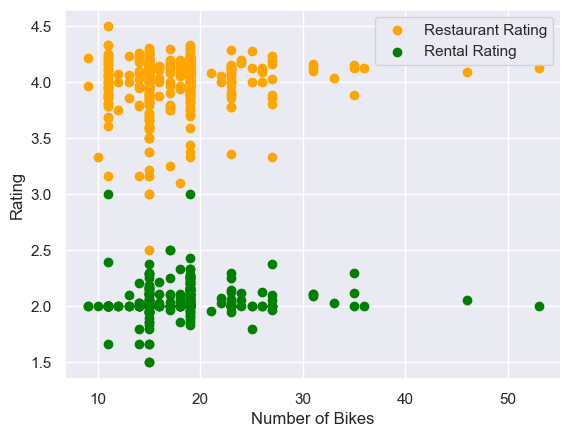

In [160]:
plt.scatter(stations_model['Number of Bikes'], stations_model['Average Restaurant Rating'], 
            color='orange',
            label='Restaurant Rating')

plt.xlabel ('Number of Bikes')

plt.scatter(stations_model['Number of Bikes'], stations_model['Average Rental Rating'], 
            color='green',
            label='Rental Rating')
plt.legend(loc = 'upper right')
plt.ylabel('Rating')

plt.title = 'Distribution of Ratings of Places of Interests with Bike stations'

**Analysis**: From the histogram, the distribution of the Number of 'Average Restaurant Rating' and 'Average Rental Rating' skews to the left with extreme outliers. Places of interests in the general area are rated highly.

The scatter plot shows no correlation between these values and Nunber of Bikes. The rating of places does not seem to be affected by the size of the neigbouring bike stations.

Text(0.5, 0, 'Number of Bikes')

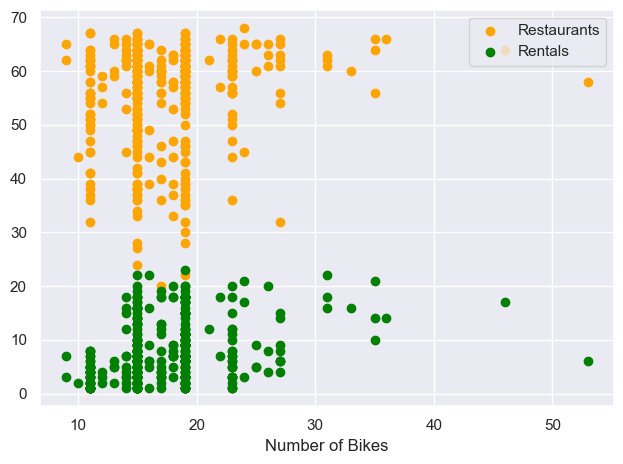

In [161]:
plt.scatter(stations_model['Number of Bikes'], 
            stations_model['Number of Restaurants'],
            marker='o',
            color='orange',
            label='Restaurants')

plt.scatter(stations_model['Number of Bikes'], 
            stations_model['Number of Rentals'],
            marker='o',
            color='green',
            label='Rentals')
plt.legend(loc = 'upper right')
plt.xlabel('Number of Bikes')

plt.title = 'Distribution of Places of Interests with Bike stations'
plt.tight_layout()

**Analysis**: This shows little to no correlation between the number of restaurants and rentals to the number of bikes. But it looks like there's a pattern between the Number of Restaurants and the Number of Car rentals. Also the scale of range in the Number of Restaurants might need to be taken into account during model building.

Summary of Prelimary Analysis:

    1. Skewed distributions of all the values.
    2. Extreme outliers for all the values which will be dealt with during model building

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Preamble:
    To create a good Database, we need to 3 distinct tables with non-duplicating information:
    
        1. `stations` - a table of stations with their ID, longitude and latitude, and number of bikes.
        2. `places` - a table of places of interest with their unique names, IDs, ratings and review counts.
        3. `stations_places` - a table showing the relationships between the stations and the nearby places of interests.
        

### 1.` stations`
The table `stations_df` already exists with most of these requirements. We just need to:
- create a separate "index" column for the SQLite database to recognize as its primary key. (the original Station ID from citybikes will not be used for the database).
- removing the information about number of restaurants, etc, and just keep information unique to the station.

In [140]:
# importing the stations_df table
stations_df = pd.read_csv('../data/stations_df.csv')
stations_df.columns

Index(['Station Name', 'Latitude', 'Longitude', 'Number of Bikes',
       'Station ID'],
      dtype='object')

In [141]:
stations = stations_df[['Station Name', 'Latitude', 'Longitude', 'Number of Bikes']].copy()
stations['ID'] = stations.index # add column index
stations = stations[['ID', 'Station Name', 'Latitude', 'Longitude', 'Number of Bikes']] # rearranging columns
stations.head()

,ID,Station Name,Latitude,Longitude,Number of Bikes
0,0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19
1,1,Maverick Square - Lewis Mall,42.368844,-71.039778,33
2,2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16
3,3,Bennington St at Byron St,42.383533,-71.016191,15
4,4,Boston East - 126 Border St,42.373312,-71.041020,15


### 2. `places`

In [142]:
points_of_interest.head()

,Name,Review Count,Ratings,Bike Station Id,Category
0,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant
1,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant
2,New Saigon,201,4.5,0,Restaurant
3,Melodias,12,4.0,0,Restaurant
4,Renegade's Pub,126,4.0,0,Restaurant


In [143]:
places = points_of_interest.groupby('Name').\
    agg({'Review Count': 'mean', 'Ratings': 'mean', 'Category': 'first'}).copy()
places['Review Count'] = round(places['Review Count']).astype(int) # keeping this an integer value
places

,Review Count,Ratings,Category
Name,,,
100% Delicias,46,1.500000,Restaurant
100% Delicias Express,7,4.000000,Restaurant
110 Grill,63,3.727273,Restaurant
110 Grill South Bay,0,4.000000,Restaurant
1260 Boylston,0,4.000000,Restaurant
...,...,...,...
Zumes Cafe House,0,4.000000,Restaurant
Zuru Zuru,0,4.000000,Restaurant
Zuru Zuru Ramen And Donburi,118,4.500000,Restaurant


In [144]:
# confirm by counting the unique names of the table
points_of_interest['Name'].nunique()

4152

In [145]:
# reindexing: 
    # reseting the index
places.reset_index(inplace=True)
# adding column index to be the primary key in the database
places['ID'] = places.index # add column index
places = places[['ID', 'Name', 'Review Count', 'Ratings', 'Category']] # rearranging columns
places['Ratings'] = places['Ratings'].round(2)
places

,ID,Name,Review Count,Ratings,Category
0,0,100% Delicias,46,1.50,Restaurant
1,1,100% Delicias Express,7,4.00,Restaurant
2,2,110 Grill,63,3.73,Restaurant
3,3,110 Grill South Bay,0,4.00,Restaurant
4,4,1260 Boylston,0,4.00,Restaurant
...,...,...,...,...,...
4147,4147,Zumes Cafe House,0,4.00,Restaurant
4148,4148,Zuru Zuru,0,4.00,Restaurant
4149,4149,Zuru Zuru Ramen And Donburi,118,4.50,Restaurant
4150,4150,Zuzu,0,4.00,Restaurant


### 3. `stations_places`


In [146]:
# use the newly created table places to add a places index to stations_and_places
stations_and_places.head()

,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Name,Review Count,Ratings,Bike Station Id,Category
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant
1,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant
2,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,New Saigon,201,4.5,0,Restaurant
3,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Melodias,12,4.0,0,Restaurant
4,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Renegade's Pub,126,4.0,0,Restaurant


In [147]:
stations_and_places['Place ID'] = 0
for idx in stations_and_places.index:
    print(idx)
#     break
    placename = stations_and_places.loc[idx, 'Name']
    index_in_places = places[places['Name'] == placename].index.values[0]
    stations_and_places.loc[idx, 'Place ID'] = index_in_places

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
24469
24470
24471
24472
24473
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
24072
24073
24074
24075
24076
24474
24475
24476
24477
24478
24479
24480
24481
24482
24483
24484
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
24077
24078
24079
24080
24081
24485
24486
24487
24488
24489
24490
24491
24492
24493
24494
24495
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
885

9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
24693
24694
24695
24696
24697
24698
24699
24700
24701
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
24702
24703
24704
24705
24706
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
24707
24708
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
24709
24710
24711
24712


10687
10688
10689
10690
24890
24891
24892
24893
24894
24895
24896
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
10691
10692
10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
24146
24147
24148
24149
24897
24898
24899
24900
24901
24902
24903
24904
24905
24906
24907
24908
24909
24910
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
10764
10765
10766
10767
10768
10769
10770
10771
10772
10773
24150
24911
24912
24913
24914
24915
24916
24917
24918
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149

11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
25083
25084
25085
25086
25087
25088
25089
25090
25091
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
24175
25092
25093
25094
25095
25096
25097
25098
25099
25100
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
24176
24177
25

2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
24195
25264
25265
25266
25267
25268
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608
12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619
12620
12621
12622
12623
12624
25269
25270
25271
25272


2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441
13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452
13453
13454
13455
13456
13457
13458
13459
13460
13461
13462
13463
13464
24215
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
13465
13466
13467
13468
13469
13470
13471
13472
13473
13474
13475
13476
13477
13478
13479
13480
13481
13482
13483
13484
13485
13486
13487
13488
13489
13490
13491
13492
13493
13494
13495
13496
13497
13498
13499
13500
13501
25393
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
13502
13503
13504
13505
13506
13507
13508
13509
13510
13511
13512
13513
13514
13515
13516
13517
13518
13519
13520
13521
13522
13523
13524
13525
13526
13527
13528
13529
13530
13531
13532
1353

14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
25526
25527
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
25528
25529
25530
25531
25532
25533
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
25534
3103
3104
3105
3106
3107
3108
3109
3110
3111

3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
15171
15172
15173
15174
15175
15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186
15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199
15200
15201
15202
15203
15204
15205
15206
15207
15208
15209
15210
15211
25658
25659
25660
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
15212
15213
15214
15215
15216
15217
15218
15219
15220
15221
15222
15223
15224
15225
15226
15227
15228
15229
15230
15231
15232
15233
15234
15235
15236
15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
15249
24258
25661
25662
25663
25664
25665
25666
25667
25668
25669
25670
25671
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
15250
15251
15252
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
1527

25849
25850
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
25851
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
25852
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
25853
25854
25855
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
16174
16175
16176
16177
16178


26028
26029
26030
26031
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
26032
26033
26034
26035
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
24304
24305
24306
24307
24308
26036
26037
26038
26039
26040
26041
26042
26043
26044
26045
26046
26047
26048
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
26049
26050
2

5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
17950
17951
17952
17953
17954
17955
17956
17957
17958
17959
17960
17961
17962
17963
17964
17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
17975
17976
17977
17978
17979
17980
17981
17982
17983
17984
17985
17986
26149
26150
26151
26152
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
17999
18000
18001
18002
18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014
18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
26153
26154
26155
26156
26157
26158
26159
26160
26161
26162
26163
26164
26165
26166
26167
26168
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
1

18823
18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
24329
26307
26308
26309
26310
26311
26312
26313
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
18865
18866
18867
18868
18869
18870
18871
26314
26315
26316
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
18872
18873
18874
18875
18876
18877
18878
18879
18880
18881
18882
18883
18884
18885
18886
18887
18888
18889
18890
26317
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
18891
18892
18893
18894
18895
18896
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
18897
18898
18899
18900
18901
18902
18903
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
18904
1

19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
24376
24377
26498
26499
26500
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
26501
26502
26503
26504
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
24378
26505
26

20780
20781
20782
20783
20784
20785
20786
20787
20788
20789
20790
20791
20792
20793
20794
20795
20796
20797
20798
20799
20800
20801
20802
20803
20804
20805
20806
20807
20808
20809
20810
20811
20812
20813
26635
26636
26637
26638
26639
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
20814
20815
20816
20817
20818
20819
20820
20821
20822
20823
20824
20825
20826
20827
20828
20829
20830
26640
26641
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
20831
20832
20833
20834
20835
20836
20837
20838
20839
20840
20841
20842
20843
20844
20845
20846
20847
20848
20849
20850
20851
20852
20853
20854
20855
20856
20857
20858
20859
20860
20861
20862
20863
20864
20865
20866
26642
26643
26644
26645
26646
26647
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
20867
20868
20869
20870
20871
20872
20873
20874
20875
20876
20877
20878
20879
20880
20881
20882
2088

7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
21669
21670
21671
21672
21673
21674
21675
21676
21677
21678
21679
21680
21681
21682
21683
21684
21685
21686
21687
21688
21689
21690
21691
21692
21693
21694
21695
21696
21697
21698
21699
21700
21701
21702
21703
21704
24401
24402
24403
24404
24405
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
21705
21706
21707
21708
21709
21710
21711
21712
21713
21714
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21737
21738
21739
21740
24406
26793
26794
26795
26796
26797
26798
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
21741
21742
21743
21744
21745
21746
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757
21758
21759
21760
21761
26799
26800
26801
26802
26803
26804
7289
7290
729

22608
22609
22610
22611
22612
26937
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
26938
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
22657
22658
22659
22660
22661
22662
22663
24421
26939
26940
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
26941
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
22682
22683
22684
22685
22686
22687
22688
22689
22690
22691
22692
22693
22694
22695
22696
22697
22698
22699
26942
7923
7

8429
8430
8431
23450
23451
23452
23453
23454
23455
23456
23457
23458
23459
23460
23461
23462
23463
23464
23465
23466
23467
23468
23469
23470
23471
23472
23473
23474
23475
23476
23477
23478
23479
23480
23481
23482
23483
23484
23485
23486
23487
23488
23489
23490
23491
23492
24447
27052
27053
27054
27055
27056
27057
27058
27059
27060
27061
27062
27063
27064
27065
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
23493
23494
23495
23496
23497
23498
23499
23500
23501
23502
23503
23504
23505
23506
23507
23508
23509
23510
23511
23512
23513
23514
23515
23516
23517
23518
23519
23520
23521
23522
23523
23524
23525
23526
23527
23528
23529
23530
23531
23532
23533
23534
24448
24449
24450
24451
24452
27066
27067
27068
27069
27070
27071
27072
27073
27074
27075
27076
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547
23548
23549

In [148]:
stations_and_places.head()

,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Name,Review Count,Ratings,Bike Station Id,Category,Place ID
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant,2157
1,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant,151
2,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,New Saigon,201,4.5,0,Restaurant,2489
3,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Melodias,12,4.0,0,Restaurant,2291
4,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Renegade's Pub,126,4.0,0,Restaurant,2981


In [149]:
stations_and_places.groupby(['Bike Station Id', 'Place ID']).size().to_frame()

0
Bike Station Id Place ID   
0               71        1
                151       1
                152       1
                229       1
                528       1
...                      ..
442             4080      1
                4105      1
                4110      1
                4119      1
                4122      1

[27210 rows x 1 columns]

In [150]:
stations_places = stations_and_places.groupby(['Bike Station Id', 'Place ID']).size().reset_index().copy()
stations_places.drop(columns=0, axis=1, inplace=True)
stations_places.rename(columns={'Bike Station Id':'Station ID'}, inplace=True)
stations_places

,Station ID,Place ID
0,0,71
1,0,151
2,0,152
3,0,229
4,0,528
...,...,...
27205,442,4080
27206,442,4105
27207,442,4110
27208,442,4119


* Now that the 3 tables are complete, we can now create the SQLite Database.
* Before then, we'll save these dataframes and confirm that it was saved properly

In [151]:
stations.to_csv('../data/stations.csv', index=False)
places.to_csv('../data/places.csv', index=False)
stations_places.to_csv('../data/stations_places.csv', index=False)

In [152]:
pd.read_csv('../data/stations.csv').head()
pd.read_csv('../data/places.csv').head()
pd.read_csv('../data/stations_places.csv').head()

,ID,Station Name,Latitude,Longitude,Number of Bikes
0,0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19
1,1,Maverick Square - Lewis Mall,42.368844,-71.039778,33
2,2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16
3,3,Bennington St at Byron St,42.383533,-71.016191,15
4,4,Boston East - 126 Border St,42.373312,-71.041020,15


,ID,Name,Review Count,Ratings,Category
0,0,100% Delicias,46,1.50,Restaurant
1,1,100% Delicias Express,7,4.00,Restaurant
2,2,110 Grill,63,3.73,Restaurant
3,3,110 Grill South Bay,0,4.00,Restaurant
4,4,1260 Boylston,0,4.00,Restaurant


,Station ID,Place ID
0,0,71
1,0,151
2,0,152
3,0,229
4,0,528


# Creating the Database

In [56]:
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine
from sqlalchemy import URL
from sqlalchemy import text

### Connecting to the database

In [57]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

connection = create_connection("../data/citybikes.sqlite")

Connection to SQLite DB successful


In [58]:

def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

In [59]:
## Inspecting our tables one more time before uploading them
stations.head()
places.head()
stations_places.head()

,ID,Station Name,Latitude,Longitude,Number of Bikes
0,0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19
1,1,Maverick Square - Lewis Mall,42.368844,-71.039778,33
2,2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16
3,3,Bennington St at Byron St,42.383533,-71.016191,15
4,4,Boston East - 126 Border St,42.373312,-71.041020,15


,ID,Name,Review Count,Ratings,Category
0,0,100% Delicias,46,1.50,Restaurant
1,1,100% Delicias Express,7,4.00,Restaurant
2,2,110 Grill,63,3.73,Restaurant
3,3,110 Grill South Bay,0,4.00,Restaurant
4,4,1260 Boylston,0,4.00,Restaurant


,Station ID,Place ID
0,0,71
1,0,151
2,0,152
3,0,229
4,0,528


In [62]:
# drop_table = '''
# DROP TABLE places;'''

# execute_query(connection, drop_table) 

Query executed successfully


### Creating the tables

In [63]:
create_stations_table = """

CREATE TABLE stations (
    'ID' INT NOT NULL PRIMARY KEY,
    'Station Name' TEXT NOT NULL,
    'Latitude' REAL NOT NULL,
    'Longitude' REAL NOT NULL,
    'Number of Bikes' INT
);
"""
execute_query(connection, create_stations_table) 

Query executed successfully


In [64]:
create_places_table = """
CREATE TABLE places (
    'ID' INT NOT NULL PRIMARY KEY,
    'Name' TEXT NOT NULL,  
    'Review Count' INT,
    'Ratings' REAL,
    'Category' TEXT
);
"""
execute_query(connection, create_places_table) 

Query executed successfully


In [65]:
create_stations_places_table = """
CREATE TABLE stations_and_places (
    'Station ID' INT,
    'Place ID' INT, 
    PRIMARY KEY ('Station ID', 'Place ID'),
    FOREIGN KEY('Station ID') REFERENCES stations('ID'),
    FOREIGN KEY('Place ID') REFERENCES places('ID')
    
);
"""
execute_query(connection, create_stations_places_table) 

Query executed successfully


In [66]:
connection.close() # close the connection for now

### Updating the tables with SQLAlchemy

* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html


In [67]:
# Creating Connection
engine = create_engine('sqlite:///../data/citybikes.sqlite') # database driver /// database
engine.connect()

In [68]:
# Update values into stations table
stations.to_sql('stations', index=False, con=engine, if_exists='append')

443

In [69]:
# Update values into stations table
places.to_sql('places', index=False, con=engine, if_exists='append')

4152

In [70]:
# Update values into stations table
stations_places.to_sql('stations_and_places', index=False, con=engine, if_exists='append')

27210

In [71]:
engine.dispose() # close connection 

## Validating the database.
The values will be retrieved from the database.



### stations

In [72]:
sql = """SELECT * FROM stations;"""

with create_engine('sqlite:///../data/citybikes.sqlite').connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,ID,Station Name,Latitude,Longitude,Number of Bikes
0,0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19
1,1,Maverick Square - Lewis Mall,42.368844,-71.039778,33
2,2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16
3,3,Bennington St at Byron St,42.383533,-71.016191,15
4,4,Boston East - 126 Border St,42.373312,-71.041020,15
...,...,...,...,...,...
438,438,Central Ave at River St,42.270947,-71.073379,15
439,439,1200 Beacon St,42.344149,-71.114674,15
440,440,Newbury St at Hereford St,42.348717,-71.085954,22
441,441,Boylston St at Dartmouth St,42.350193,-71.077442,19


In [73]:
(df == stations).value_counts() # all True confirming that they're identical

ID    Station Name  Latitude  Longitude  Number of Bikes
True  True          True      True       True               443
dtype: int64

### places

In [74]:
sql = """SELECT * FROM places;"""

with create_engine('sqlite:///../data/citybikes.sqlite').connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,ID,Name,Review Count,Ratings,Category
0,0,100% Delicias,46,1.50,Restaurant
1,1,100% Delicias Express,7,4.00,Restaurant
2,2,110 Grill,63,3.73,Restaurant
3,3,110 Grill South Bay,0,4.00,Restaurant
4,4,1260 Boylston,0,4.00,Restaurant
...,...,...,...,...,...
4147,4147,Zumes Cafe House,0,4.00,Restaurant
4148,4148,Zuru Zuru,0,4.00,Restaurant
4149,4149,Zuru Zuru Ramen And Donburi,118,4.50,Restaurant
4150,4150,Zuzu,0,4.00,Restaurant


In [75]:
(df == places).value_counts() # all True confirming that they're identical

ID    Name  Review Count  Ratings  Category
True  True  True          True     True        4152
dtype: int64

### stations_places

In [76]:
sql = """SELECT * FROM stations_and_places;"""

with create_engine('sqlite:///../data/citybikes.sqlite').connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,Station ID,Place ID
0,0,71
1,0,151
2,0,152
3,0,229
4,0,528
...,...,...
27205,442,4080
27206,442,4105
27207,442,4110
27208,442,4119


In [77]:
(df == stations_places).value_counts() # all True confirming that they're identical

Station ID  Place ID
True        True        27210
dtype: int64